In [8]:
from skimage.transform import resize
from nilearn import plotting
import nibabel as nib
import numpy as np
import torch
import ipdb
import csv
import os
import re

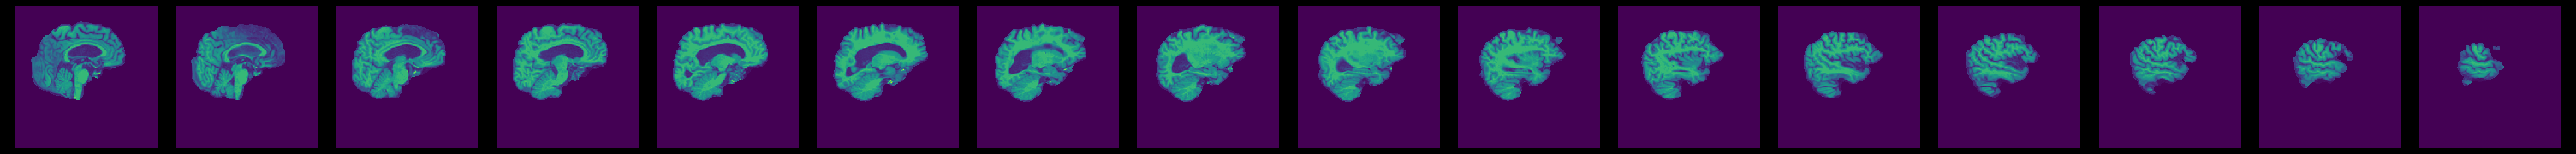

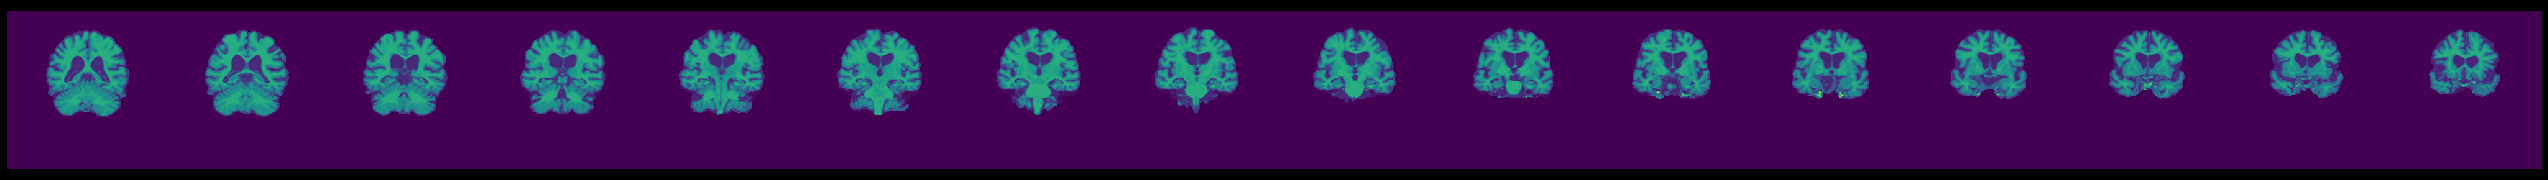

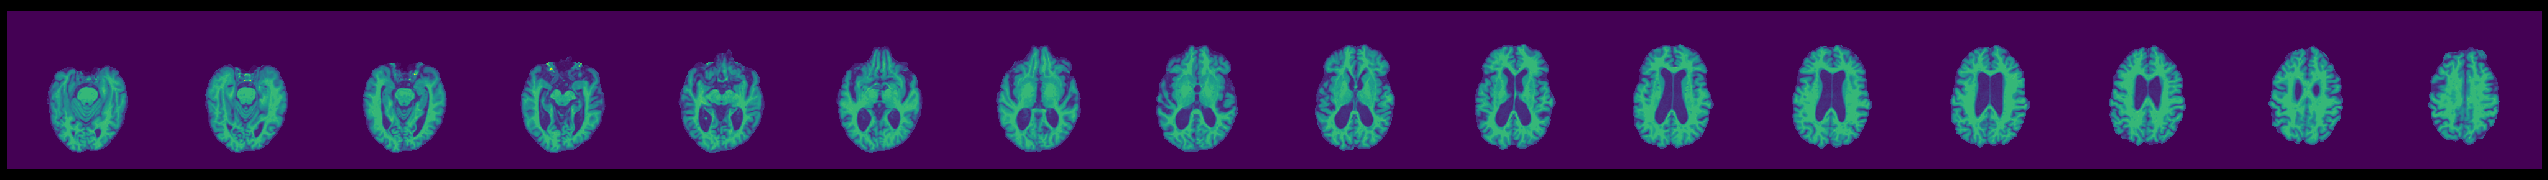

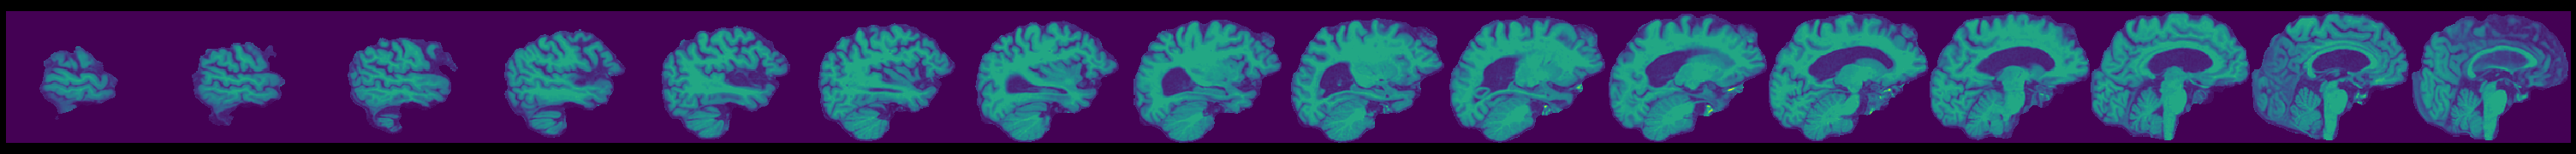

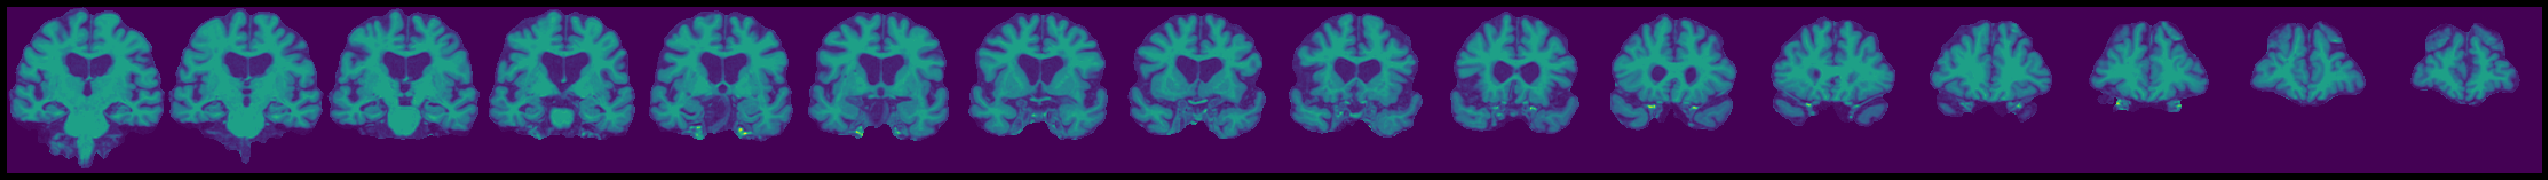

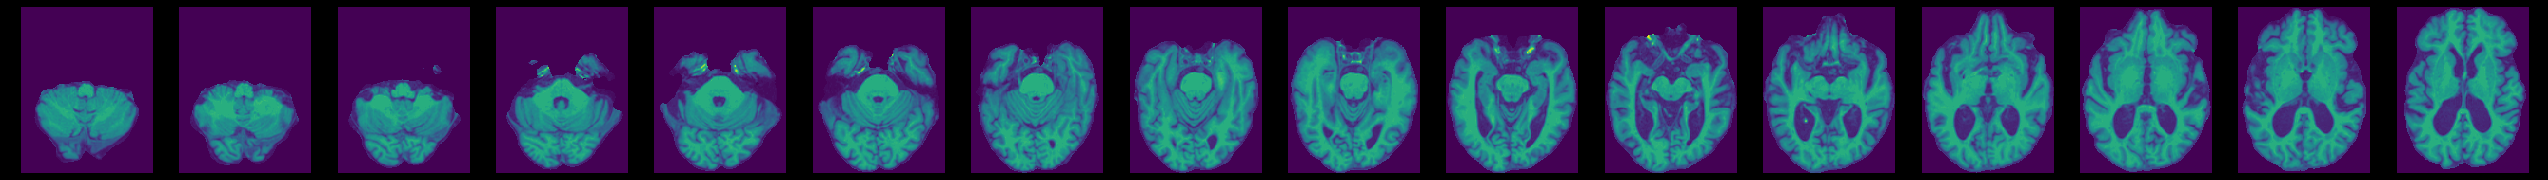

In [10]:
mgz_path = '../ADNI/002_S_0782/FreeSurfer_Cross-Sectional_Processing_brainmask/2007-04-11_08_07_06.0/S29564/mri/brainmask.mgz'
nii_path = '../ADNI/002_S_0782/FreeSurfer_Cross-Sectional_Processing_brainmask/2007-04-11_08_07_06.0/S29564/mri/test_image.nii'
padding = 0

img = nib.load(mgz_path)
np_img = np.array(img.get_fdata())
plotting.plot_img(img,cut_coords=arr,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
plotting.plot_img(img,cut_coords=arr,draw_cross=False,annotate=False,black_bg=True,display_mode='y')
plotting.plot_img(img,cut_coords=arr,draw_cross=False,annotate=False,black_bg=True,display_mode='z')
plotting.show()

# clean X 
x_len, y_len, z_len = len(np_img), len(np_img[0]), len(np_img[0, 0])
zero_mask = np.zeros((y_len, z_len)) 
del_inds = []
for i in range(x_len):
    if np.sum(np_img[i] != zero_mask) == 0:
        del_inds.append(i)
np_img = np.delete(np_img, del_inds, 0)
# add paddings
np_img = np.insert(np_img, [0 for i in range(padding)], zero_mask, 0)
np_img = np.insert(np_img, [len(np_img) for i in range(padding)], zero_mask, 0)

# clean Y
x_len, y_len, z_len = len(np_img), len(np_img[0]), len(np_img[0, 0])
zero_mask = np.zeros((x_len, z_len)) 
del_inds = []
for i in range(y_len):
    if np.sum(np_img[:, i] != zero_mask) == 0:
        del_inds.append(i)
np_img = np.delete(np.swapaxes(np_img, 0, 1), del_inds, 0)
np_img = np.swapaxes(np_img, 0, 1)
# add paddings
np_img = np.insert(np_img, [0 for i in range(padding)], np.zeros(z_len), 1)
np_img = np.insert(np_img, [len(np_img[0]) for i in range(padding)], np.zeros(z_len), 1)

# clean Z
x_len, y_len, z_len = len(np_img), len(np_img[0]), len(np_img[0, 0])
zero_mask = np.zeros((x_len, y_len)) 
del_inds = []
for i in range(z_len):
    if np.sum(np_img[:, :, i] != zero_mask) == 0:
        del_inds.append(i)
np_img = np.delete(np.swapaxes(np_img, 0, 2), del_inds, 0)
np_img = np.swapaxes(np_img, 0, 2)
# add paddings
np_img = np.insert(np_img, [0 for i in range(padding)], 0, 2)
np_img = np.insert(np_img, [len(np_img[0][0]) for i in range(padding)], 0, 2)
    
# write to disk
feat = nib.Nifti1Image(np_img, img.affine)
nib.save(feat, nii_path)

plotting.plot_img(feat,cut_coords=arr,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
plotting.plot_img(feat,cut_coords=arr,draw_cross=False,annotate=False,black_bg=True,display_mode='y')
plotting.plot_img(feat,cut_coords=arr,draw_cross=False,annotate=False,black_bg=True,display_mode='z')
plotting.show()